In [1]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
import os
import re
import seaborn as sns


# Set plot style and figure size
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
# regions contains all the necessary information including the association of each illustration to cluster part and book

df = pd.read_csv('../csv/regions.csv', 
                 skipinitialspace=True,     
                 na_values=['', ' '],       
                 dtype=str)                 

# Clean column names and remove completely empty columns
df.columns = df.columns.str.strip()
df = df.loc[:, ~df.columns.str.match(r'^\s*$')]  # Remove columns with empty/whitespace names
df = df.dropna(axis=1, how='all')  # Remove columns that are entirely empty

# Clean all string data by stripping whitespace
df = df.map(lambda x: x.strip() if isinstance(x, str) else x)

print(f"Loaded {len(df)} rows and {len(df.columns)} columns")
print(f"Columns: {list(df.columns)}")
df.head(2)

Loaded 8252 rows and 11 columns
Columns: ['region', 'type', 'cluster_name', 'pageURL', 'coordinates', 'book_id', 'book_title', 'page_number', 'part', 'part_title', 'part_id']


,region,type,cluster_name,pageURL,coordinates,book_id,book_title,page_number,part,part_title,part_id
0,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,Content Illustration,SAC_SIL_00002,http://devmeta.sphaera.mpiwg-berlin.mpg.de/res...,"198,490,412,297",2232,De sphaera mundi: Et Témporis ratione,71,http://sphaera.mpiwg-berlin.mpg.de/id/part/22a...,Witekind's treatise on the Sphere,520
1,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,Content Illustration,SAC_SIL_00002,http://devmeta.sphaera.mpiwg-berlin.mpg.de/res...,"247,502,364,304",2233,De sphaera mundi: et temporis ratione,71,http://sphaera.mpiwg-berlin.mpg.de/id/part/22a...,Witekind's treatise on the Sphere,520


In [4]:
# the following mapping provides an overlay data cleaning. Clusters in the keys will be merged with clusters in the values 

cluster_merge_mapping = {
    'SAC_SIL_01356': ['SAC_SIL_01420','SAC_SIL_01638'], 
    'SAC_SIL_01833': ['SAC_SIL_03700'],
    'SAC_SIL_01935': ['SAC_SIL_00424'],
    'SAC_SIL_01505': ['SAC_SIL_00424', 'SAC_SIL_01811'],
    'SAC_SIL_01471': ['SAC_SIL_02862','SAC_SIL_03012'],
    'SAC_SIL_01183': ['SAC_SIL_00839','SAC_SIL_00855'],
    'SAC_SIL_00870': ['SAC_SIL_03754'],
    'SAC_SIL_03089': ['SAC_SIL_00433'],
    'SAC_SIL_02263': ['SAC_SIL_01510'],
    'SAC_SIL_03641': ['SAC_SIL_01492'],
    'SAC_SIL_03823': ['SAC_SIL_00119'],
    'SAC_SIL_01448': ['SAC_SIL_00150','SAC_SIL_00262'],
    'SAC_SIL_00391': ['SAC_SIL_00150','SAC_SIL_00262', 'SAC_SIL_00263'],
    'SAC_SIL_01429': ['SAC_SIL_00839', 'SAC_SIL_01055','SAC_SIL_01368'],
    'SAC_SIL_01794': ['SAC_SIL_01507', 'SAC_SIL_01647'],
    'SAC_SIL_01526': ['SAC_SIL_03688', 'SAC_SIL_01943'],
    'SAC_SIL_02026': ['SAC_SIL_00297','SAC_SIL_01496'],
    'SAC_SIL_00104': ['SAC_SIL_00975', 'SAC_SIL_00424'],
    'SAC_SIL_00068': ['SAC_SIL_01329', 'SAC_SIL_01344'],
    'SAC_SIL_01478': ['SAC_SIL_01953','SAC_SIL_02015'],
    'SAC_SIL_00260': ['SAC_SIL_01878'],
    'SAC_SIL_01220': ['SAC_SIL_00071', 'SAC_SIL_00839', 'SAC_SIL_00855'],
    'SAC_SIL_01467': ['SAC_SIL_00428', 'SAC_SIL_00973'],
    'SAC_SIL_00963': ['SAC_SIL_00034', 'SAC_SIL_00853', 'SAC_SIL_01016'],
    'SAC_SIL_01615': ['SAC_SIL_01224', 'SAC_SIL_00045'],
    'SAC_SIL_01638': ['SAC_SIL_03692', 'SAC_SIL_01420'],
    'SAC_SIL_02175': ['SAC_SIL_00931'],
    'SAC_SIL_02540': ['SAC_SIL_03755', 'SAC_SIL_03045', 'SAC_SIL_00947', 'SAC_SIL_00848'],
    'SAC_SIL_02852': ['SAC_SIL_00153'],
    'SAC_SIL_01134': ['SAC_SIL_02336'],
    'SAC_SIL_01784': ['SAC_SIL_01942', 'SAC_SIL_01871', 'SAC_SIL_01616'],
    'SAC_SIL_00841': ['SAC_SIL_00043'],
    'SAC_SIL_01638': ['SAC_SIL_03692'],
    'SAC_SIL_01467': ['SAC_SIL_00973', 'SAC_SIL_00428'],
    'SAC_SIL_01615': ['SAC_SIL_00045', 'SAC_SIL_01224'],
    'SAC_SIL_00963': ['SAC_SIL_01016', 'SAC_SIL_00853', 'SAC_SIL_00034'],
    'SAC_SIL_00428': ['SAC_SIL_00973'],
    'SAC_SIL_03521': ['SAC_SIL_01878'],
    'SAC_SIL_03540': ['SAC_SIL_00975'],
    'SAC_SIL_00435': ['SAC_SIL_03610'],
    'SAC_SIL_01224': ['SAC_SIL_03634'],
    'SAC_SIL_00390': ['SAC_SIL_00434', 'SAC_SIL_00237'],
    'SAC_SIL_03863': ['SAC_SIL_01299']

}

In [5]:
def validate_cluster_mapping(mapping):
    """Validate the cluster mapping for potential issues."""
    issues = []
    
    # Check for circular references (key appears in its own values)
    for key, values in mapping.items():
        if key in values:
            issues.append(f"Circular reference: {key} maps to itself")
    
    # Check for conflicting mappings (A->B and B->A)
    for key, values in mapping.items():
        for value in values:
            if value in mapping and key in mapping[value]:
                issues.append(f"Mutual mapping conflict: {key} <-> {value}")
    
    # Check for chains that could be simplified (A->B, B->C could be A->C)
    chains = []
    for key, values in mapping.items():
        for value in values:
            if value in mapping:
                chains.append(f"{key} -> {value} -> {mapping[value]}")
    
    if chains:
        print("Potential chain mappings found (consider simplifying):")
        for chain in chains:  
            print(f"  - {chain}")
        if len(chains) > 5:
            print(f"  ... and {len(chains) - 5} more")
    
    if issues:
        print("Mapping validation issues found:")
        for issue in issues:
            print(f"  - {issue}")
    else:
        print("Cluster mapping validation passed")
    
    return len(issues) == 0

# Run validation
validate_cluster_mapping(cluster_merge_mapping)

Potential chain mappings found (consider simplifying):
  - SAC_SIL_01356 -> SAC_SIL_01638 -> ['SAC_SIL_03692']
  - SAC_SIL_01467 -> SAC_SIL_00428 -> ['SAC_SIL_00973']
  - SAC_SIL_01615 -> SAC_SIL_01224 -> ['SAC_SIL_03634']
Cluster mapping validation passed


True

In [6]:
# function to apply our mapping

def merge_clusters(df, mapping, cluster_column='cluster_name'):

    rows_to_add = []
    
    for _, row in df.iterrows():
        cluster = row[cluster_column]
        
        if cluster in mapping:
            # Create multiple rows for each mapped cluster
            for new_cluster in mapping[cluster]:
                new_row = row.copy()
                new_row[cluster_column] = new_cluster
                rows_to_add.append(new_row)
        else:
            # Keep original row if not in mapping
            rows_to_add.append(row)
    
    # Create result DataFrame in one operation
    result_df = pd.DataFrame(rows_to_add, columns=df.columns)
    return result_df.reset_index(drop=True)

In [7]:
# apply our mapping 

df = merge_clusters(df, cluster_merge_mapping)


In [8]:
df[df['cluster_name']=='SAC_SIL_01935']

,region,type,cluster_name,pageURL,coordinates,book_id,book_title,page_number,part,part_title,part_id


In [11]:
# Since I haven't included relevant metadata like publisher and place in the original PDF I am reading it in via a book csv

df_books = pd.read_csv('../csv/books.csv', 
                       skipinitialspace=True,
                       na_values=['', ' '],
                       dtype=str)

# Clean column names and remove completely empty columns
df_books.columns = df_books.columns.str.strip()
df_books = df_books.loc[:, ~df_books.columns.str.match(r'^\s*$')]
df_books = df_books.dropna(axis=1, how='all')

# Clean all string data by stripping whitespace
df_books = df_books.map(lambda x: x.strip() if isinstance(x, str) else x)

# Create publisher and place mappings
publisher_mapping = dict(zip(df_books['custom_identifier'], df_books['publishers']))
place_mapping = dict(zip(df_books['custom_identifier'], df_books['place']))

# ad publisher and place to our original df
df['part_publisher'] = df['book_id'].map(publisher_mapping)
df['part_place'] = df['book_id'].map(place_mapping)

In [12]:
# Create an identifier by combining book and part
df['individual_part'] = df['part_id'].astype(str) + '_' + df['book_id'].astype(str)

df.head(1)

,region,type,cluster_name,pageURL,coordinates,book_id,book_title,page_number,part,part_title,part_id,part_publisher,part_place,individual_part
0,http://dev.sphaera.mpiwg-berlin.mpg.de/contain...,Content Illustration,SAC_SIL_00002,http://devmeta.sphaera.mpiwg-berlin.mpg.de/res...,"198,490,412,297",2232,De sphaera mundi: Et Témporis ratione,71,http://sphaera.mpiwg-berlin.mpg.de/id/part/22a...,Witekind's treatise on the Sphere,520,"Harnisch, Matthäus",Neustadt an der Weinstraße,520_2232


In [13]:
# Create one-hot encoding for each feature (cluster element)
cluster_dummies = pd.get_dummies(df['cluster_name'], prefix='cluster')

# Combine with original df
df_with_dummies = pd.concat([df, cluster_dummies], axis=1)

# Group by individual_part and sum the occurrences to get cluster counts per part
cluster_df = df_with_dummies.groupby('individual_part')[cluster_dummies.columns].sum()

print(f"{cluster_df.shape[0]} parts × {cluster_df.shape[1]} clusters")
cluster_df.head()

348 parts × 1709 clusters


,cluster_SAC_SIL_00002,cluster_SAC_SIL_00003,cluster_SAC_SIL_00004,cluster_SAC_SIL_00008,cluster_SAC_SIL_00009,cluster_SAC_SIL_00012,cluster_SAC_SIL_00013,cluster_SAC_SIL_00014,cluster_SAC_SIL_00015,cluster_SAC_SIL_00017,...,cluster_SAC_SIL_03897,cluster_SAC_SIL_03899,cluster_SAC_SIL_03900,cluster_SAC_SIL_03901,cluster_SAC_SIL_03903,cluster_SAC_SIL_06001,cluster_SAC_SIL_06002,cluster_SAC_SIL_06003,cluster_SAC_SIL_06005,cluster_SAC_SIL_06008
individual_part,,,,,,,,,,,,,,,,,,,,,
100_1611,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100_1613,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100_1616,0,0,0,0,1,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100_1618,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100_1621,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Binarize because we do ignore multiple repetition of same illustration in a part 
cluster_df_binary = (cluster_df >= 1).astype(int)
cluster_df_binary.to_csv('cluster_df_binary.csv', index=True)

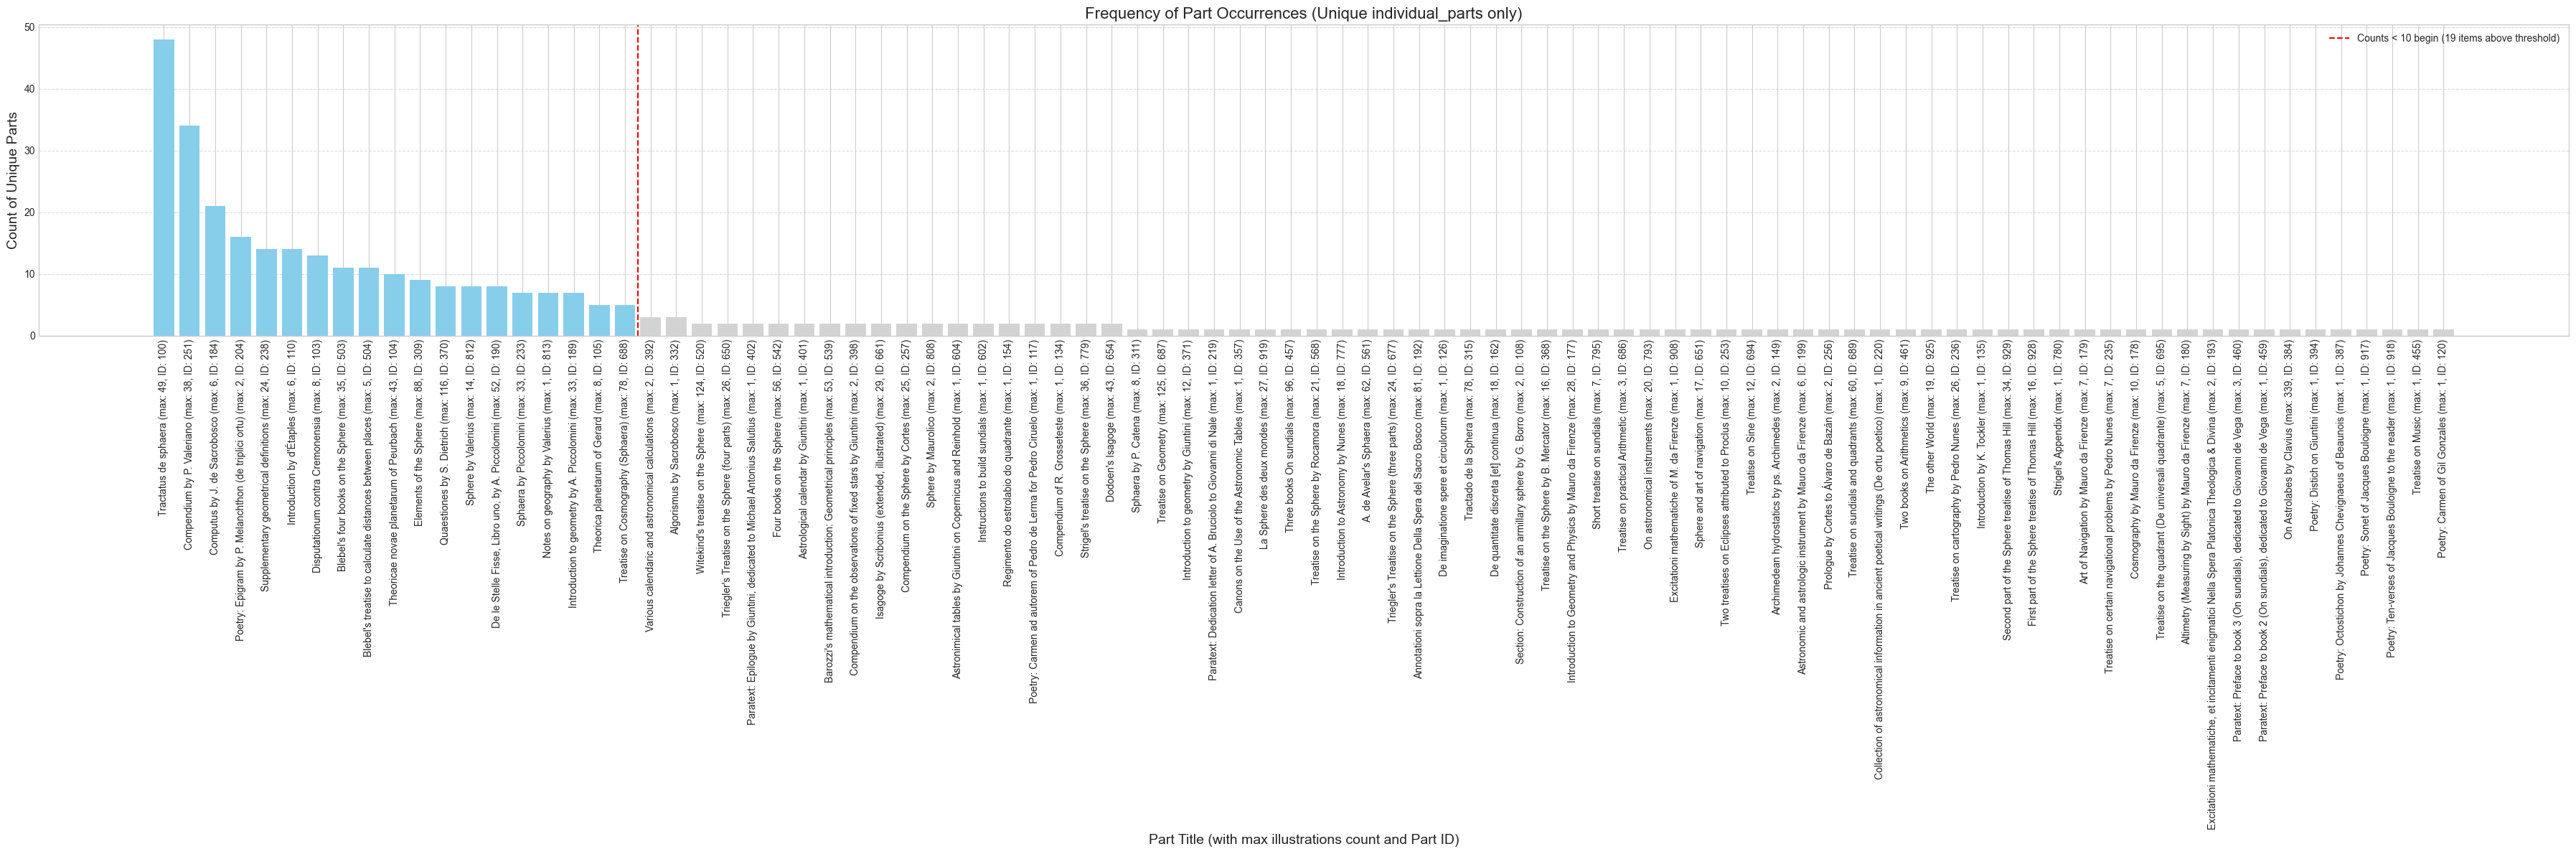

Total printed part tokens: 348
Total distinct parts: 90
Number of part_ids with ≥5 occurrences: 19
Number of part_ids with <5 occurrences: 71
Most common part_id: 100 with 48 occurrences
Title: Tractatus de sphaera
Max illustrations: 49


In [15]:
# get overall statistics for parts containing illustrations  

def extract_part_id(value):
    match = re.match(r'(\d+)_', str(value))
    return match.group(1) if match else str(value)

# Step 1: Get unique individual_parts and extract part_ids
df_unique = df.drop_duplicates(subset=['individual_part']).copy()
df_unique['part_id'] = df_unique['individual_part'].apply(extract_part_id)

# Step 2: Calculate max illustration counts per part
row_sums = cluster_df.sum(axis=1) 
counts_df = pd.DataFrame({'counts': row_sums, 'part_id': row_sums.index.map(extract_part_id)})
max_counts_by_part = counts_df.groupby('part_id')['counts'].max()

# Step 3: Count occurrences and create mappings
part_id_counts = df_unique['part_id'].value_counts().sort_values(ascending=False)
part_id_to_title = df_unique.drop_duplicates('part_id').set_index('part_id')['part_title'].to_dict()

# Step 4: Create labels with titles, max counts, and IDs
titles_with_info = [
    f"{part_id_to_title.get(pid, 'Unknown')} (max: {max_counts_by_part.get(pid, 0)}, ID: {pid})" 
    for pid in part_id_counts.index
]

# Step 5: Find threshold where counts drop below 5
threshold_mask = part_id_counts.values >= 5
threshold_index = np.sum(threshold_mask)

# Step 6: Create visualization
plt.figure(figsize=(max(26, len(part_id_counts) * 0.4), 12))

# Plot bars with different colors for above/below threshold
colors = ['skyblue' if above_threshold else 'lightgray' 
          for above_threshold in threshold_mask]
bars = plt.bar(range(len(part_id_counts)), part_id_counts.values, color=colors)

# Add threshold line
if threshold_index < len(part_id_counts):
    plt.axvline(x=threshold_index - 0.5, color='red', linestyle='--', 
                label=f'Counts < 10 begin ({threshold_index} items above threshold)')

# Formatting
plt.title('Frequency of Part Occurrences (Unique individual_parts only)', fontsize=16)
plt.xlabel('Part Title (with max illustrations count and Part ID)', fontsize=14)
plt.ylabel('Count of Unique Parts', fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

# Set x-axis labels
plt.xticks(range(len(part_id_counts)), titles_with_info, rotation=90, ha='center')
plt.subplots_adjust(bottom=0.5)
plt.tight_layout()
plt.show()

# Print statistics
print(f"Total printed part tokens: {len(df_unique)}")
print(f"Total distinct parts: {len(part_id_counts)}")
print(f"Number of part_ids with ≥5 occurrences: {threshold_index}")
print(f"Number of part_ids with <5 occurrences: {len(part_id_counts) - threshold_index}")

# Most common part info
most_common_id = part_id_counts.index[0]
print(f"Most common part_id: {most_common_id} with {part_id_counts.values[0]} occurrences")
print(f"Title: {part_id_to_title.get(most_common_id, 'Unknown')}")
print(f"Max illustrations: {max_counts_by_part.get(most_common_id, 0)}")

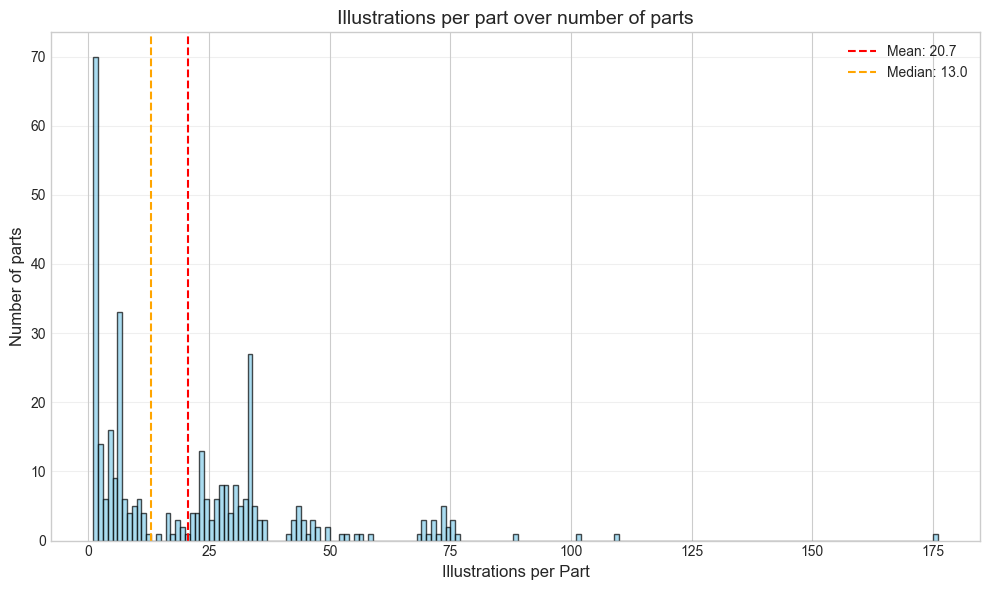

In [16]:
import matplotlib.pyplot as plt

# Calculate row sums and create counts DataFrame
row_sums = cluster_df_binary.sum(axis=1)
counts = pd.DataFrame({'counts': row_sums}, index=cluster_df_binary.index)

plt.figure(figsize=(10, 6))

# Create bins for histogram - use integer bins for count data
min_count, max_count = int(counts['counts'].min()), int(counts['counts'].max())
bins = range(min_count, max_count + 2)

plt.hist(counts['counts'], bins=bins, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Illustrations per part over number of parts', fontsize=14)
plt.xlabel('Illustrations per Part', fontsize=12)
plt.ylabel('Number of parts', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add some helpful annotations
plt.axvline(counts['counts'].mean(), color='red', linestyle='--', 
           label=f'Mean: {counts["counts"].mean():.1f}')
plt.axvline(counts['counts'].median(), color='orange', linestyle='--', 
           label=f'Median: {counts["counts"].median():.1f}')
plt.legend()

plt.tight_layout()
plt.show()

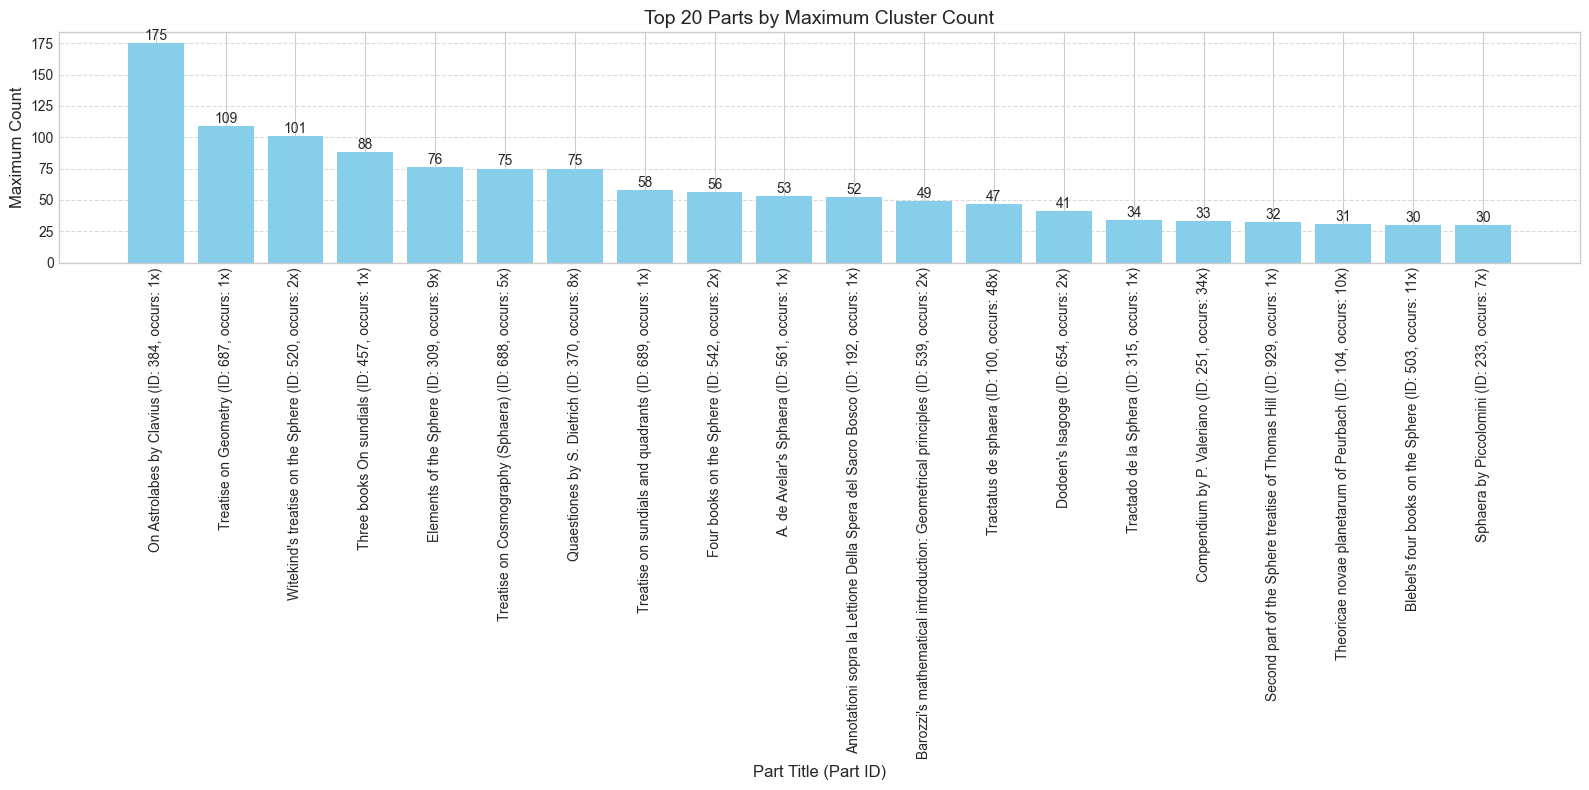

In [17]:
# display parts by the maximum illustration number

def extract_part_id(index_value):
    """Extract part_id from index (everything before the underscore)"""
    match = re.match(r'(\d+)_', str(index_value))
    return match.group(1) if match else str(index_value)

# Calculate counts and extract part_ids
row_sums = cluster_df_binary.sum(axis=1)
counts = pd.DataFrame({
    'counts': row_sums,
    'part_id': row_sums.index.map(extract_part_id)
}, index=cluster_df_binary.index)

# Find max count and reoccurrence frequency for each part_id
part_stats = counts.groupby('part_id').agg({
    'counts': ['max', 'count']
}).reset_index()
part_stats.columns = ['part_id', 'max_count', 'reoccurrence_count']
max_counts_by_part = part_stats.sort_values('max_count', ascending=False)

# Create part_id to title mapping
if 'part_title' in df.columns:
    part_id_to_title = df.drop_duplicates('part_id').set_index('part_id')['part_title'].to_dict()
else:
    # Fallback to placeholder titles
    part_id_to_title = {pid: f"Part {pid}" for pid in max_counts_by_part['part_id']}

# Add titles to the results DataFrame
max_counts_by_part['part_title'] = max_counts_by_part['part_id'].map(
    lambda pid: part_id_to_title.get(pid, f"Part {pid}")
)

# Visualization: Top 20 parts by max count
top_n = 20
top_parts = max_counts_by_part.head(top_n)

plt.figure(figsize=(16, 8))
bars = plt.bar(range(len(top_parts)), top_parts['max_count'], color='skyblue')

# Create combined labels with part ID and reoccurrence count
labels = [f"{title} (ID: {pid}, occurs: {reoccur}x)" 
          for title, pid, reoccur in zip(top_parts['part_title'], 
                                       top_parts['part_id'], 
                                       top_parts['reoccurrence_count'])]
plt.xticks(range(len(top_parts)), labels, rotation=90, ha='center')

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.1,
             f'{height:.0f}', ha='center', va='bottom')

plt.title(f'Top {top_n} Parts by Maximum Cluster Count', fontsize=14)
plt.xlabel('Part Title (Part ID)', fontsize=12)
plt.ylabel('Maximum Count', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.subplots_adjust(bottom=0.4)
plt.tight_layout()
plt.show()

## Analyze the part-publisher groups

In [18]:
def extract_part_and_book_id(individual_part):
    """Extract part and book ID from individual_part column"""
    match = re.match(r'^(\d+)_(\d+)$', individual_part)
    if match:
        return {
            'part': match.group(1),
            'bookId': match.group(2)
        }
    return None

def create_enhanced_dataset():
    """Create enhanced dataset using existing cluster_df_binary and publisher_mapping"""
    print(f"Processing {cluster_df_binary.shape[0]} rows with {cluster_df_binary.shape[1]} features")
    
    enhanced_data = []
    
    for idx in cluster_df_binary.index:
        part_info = extract_part_and_book_id(idx)
        if part_info:
            book_id_str = part_info['bookId']
            publisher = publisher_mapping.get(book_id_str)
            
            # Check if publisher exists and is not NaN
            if publisher and pd.notna(publisher):
                row_dict = cluster_df_binary.loc[idx].to_dict()
                row_dict['individual_part'] = idx
                row_dict['part'] = part_info['part']
                row_dict['bookId'] = part_info['bookId']
                row_dict['publisher'] = publisher
                enhanced_data.append(row_dict)
    
    enhanced_df = pd.DataFrame(enhanced_data)
    print(f"Created enhanced dataset: {enhanced_df.shape[0]} rows with publisher information")
    
    return enhanced_df

def analyze_deviations(enhanced_df):
    """Analyze deviations in each part-publisher group"""
    feature_columns = [col for col in enhanced_df.columns if col.startswith('cluster_')]
    print(f"Analyzing {len(feature_columns)} features across part-publisher groups")
    
    grouped = enhanced_df.groupby(['part', 'publisher'])
    deviation_results = []
    
    for (part, publisher), group in grouped:
        reference_row = group.iloc[0]
        
        deviating_rows = []
        for idx, row in group.iterrows():
            deviating_features = []
            
            for feature in feature_columns:
                if row[feature] != reference_row[feature]:
                    deviating_features.append(feature)
            
            if deviating_features:
                deviating_rows.append({
                    'individual_part': row['individual_part'],
                    'deviating_features': deviating_features
                })
        
        deviation_results.append({
            'part': part,
            'publisher': publisher,
            'total_items': len(group),
            'deviating_items': len(deviating_rows),
            'deviation_rate': len(deviating_rows) / len(group) * 100 if len(group) > 0 else 0,
            'deviations': deviating_rows
        })
    
    deviation_df = pd.DataFrame(deviation_results)
    return deviation_df, feature_columns

def analyze_feature_deviations(deviation_df, feature_columns):
    """Analyze which features deviate most frequently"""
    feature_deviations = {feature: 0 for feature in feature_columns}
    total_checks = 0
    
    for _, row in deviation_df.iterrows():
        for deviation in row['deviations']:
            for feature in deviation['deviating_features']:
                feature_deviations[feature] += 1
        
        total_checks += row['total_items'] * len(feature_columns)
    
    feature_stats = pd.DataFrame([
        {'feature': feature, 'count': count, 'rate': count / total_checks * 100}
        for feature, count in feature_deviations.items() if count > 0
    ]).sort_values('count', ascending=False)
    
    return feature_stats

def analyze_multi_publisher_parts(deviation_df):
    """Identify parts published by multiple publishers"""
    part_publishers = deviation_df.groupby('part')['publisher'].agg(['nunique', list])
    multi_publisher_parts = part_publishers[part_publishers['nunique'] > 1].sort_values('nunique', ascending=False)
    
    return multi_publisher_parts

def create_visualizations(deviation_df, feature_stats, multi_publisher_parts):
    """Create visualizations and print analysis results"""
    # Summary statistics
    total_groups = len(deviation_df)
    groups_with_deviations = len(deviation_df[deviation_df['deviating_items'] > 0])
    total_items = deviation_df['total_items'].sum()
    total_deviating_items = deviation_df['deviating_items'].sum()
    
    print("\n=== DEVIATION ANALYSIS SUMMARY ===")
    print(f"Total part-publisher groups: {total_groups}")
    print(f"Groups with deviations: {groups_with_deviations} ({groups_with_deviations/total_groups*100:.2f}%)")
    print(f"Total individual parts: {total_items}")
    print(f"Deviating parts: {total_deviating_items} ({total_deviating_items/total_items*100:.2f}%)\n")
    
    # Top deviating groups
    deviating_groups = deviation_df[deviation_df['deviating_items'] > 0].sort_values('deviation_rate', ascending=False)
    
    print("=== ALL DEVIATING GROUPS ===")
    print(deviating_groups[['part', 'publisher', 'deviating_items', 'total_items', 'deviation_rate']].to_string(index=False))
    
    # Top deviating features
    print("\n=== TOP 10 DEVIATING FEATURES ===")
    print(feature_stats.head(10).to_string(index=False))
 
    # Multi-publisher parts
    print("\n=== PARTS PUBLISHED BY MULTIPLE PUBLISHERS ===")
    multi_pub_df = multi_publisher_parts.reset_index()
    print(multi_pub_df.head(10)[['part', 'nunique']].to_string(index=False, 
                                                             header=['Part', 'Publisher Count']))
    
    # Most consistent publishers
    publisher_stats = deviation_df.groupby('publisher').agg({
        'part': 'count',
        'deviating_items': 'sum',
        'total_items': 'sum'
    }).rename(columns={'part': 'total_groups'})
    
    publisher_stats['deviation_rate'] = publisher_stats['deviating_items'] / publisher_stats['total_items'] * 100
    publisher_stats['groups_with_deviations'] = deviation_df[deviation_df['deviating_items'] > 0].groupby('publisher').size()
    publisher_stats['groups_with_deviations'] = publisher_stats['groups_with_deviations'].fillna(0)
    publisher_stats['group_consistency'] = (1 - publisher_stats['groups_with_deviations'] / publisher_stats['total_groups']) * 100
    
    consistent_publishers = publisher_stats[publisher_stats['total_groups'] >= 2].sort_values('total_groups', ascending=False)
    
    print("\n=== MOST CONSISTENT PUBLISHERS (min 2 groups) ===")
    print(consistent_publishers.head(10)[['total_groups', 'deviation_rate', 'group_consistency']].to_string())
    
    return deviating_groups, feature_stats, consistent_publishers



In [19]:
# Run the analysis
enhanced_df = create_enhanced_dataset()
deviation_df, feature_columns = analyze_deviations(enhanced_df)
feature_stats = analyze_feature_deviations(deviation_df, feature_columns)
multi_publisher_parts = analyze_multi_publisher_parts(deviation_df)

deviating_groups, feature_stats, consistent_publishers = create_visualizations(
    deviation_df, feature_stats, multi_publisher_parts)

Processing 348 rows with 1709 features
Created enhanced dataset: 307 rows with publisher information
Analyzing 1709 features across part-publisher groups

=== DEVIATION ANALYSIS SUMMARY ===
Total part-publisher groups: 193
Groups with deviations: 29 (15.03%)
Total individual parts: 307
Deviating parts: 63 (20.52%)

=== ALL DEVIATING GROUPS ===
part                                                        publisher  deviating_items  total_items  deviation_rate
 100                                             Sessa I., Melchiorre                9           10       90.000000
 100                                     Heirs of Melchiorre Sessa I.                6            7       85.714286
 238                                     Heirs of Melchiorre Sessa I.                6            7       85.714286
 309                                         Krafft the Elder, Johann                5            6       83.333333
 238                                             Sessa I., Melchiorre     

In [20]:
import os
import re
import pandas as pd
import numpy as np

def create_iiif_url(page_url, coordinates):
    """Create IIIF URL from page URL and coordinates"""
    match = re.search(r'sphaera%2F([^%]+_[^%]+_\d+%2Fpageimg%2F[^%]+\.jpg)', page_url)
    if not match:
        print(f"Failed to match URL pattern in: {page_url}")
        return None
    
    path = match.group(1).replace('%2F', '!')
    coords = coordinates.split(',')
    
    base_url = "https://db.sphaera.mpiwg-berlin.mpg.de/Scaler/IIIF/"
    final_url = f"{base_url}permanent!sphaera!{path}/{coords[0]},{coords[1]},{coords[2]},{coords[3]}/!300,300/0/default.jpg"
    return final_url

def create_part_publisher_matrix(df, cluster_df_binary, df_books, part, publisher):
    # Step 1: Get all individual parts for this part-publisher combination
    # First, get book IDs for this publisher
    publisher_books = df_books[df_books['publishers'] == publisher]['custom_identifier'].tolist()
    
    # Find all individual parts that match the part and have books from this publisher
    individual_parts = []
    part_to_year = {}  # Dictionary to store year for each part
    
    for book_id in publisher_books:
        part_id = f"{part}_{book_id}"
        if part_id in cluster_df_binary.index:
            individual_parts.append(part_id)
            # Get the year for this book
            year = df_books[df_books['custom_identifier'] == book_id]['year_published_from'].values[0]
            part_to_year[part_id] = year
    
    if not individual_parts:
        return f"No individual parts found for Part {part}, Publisher {publisher}"
    
    # Sort individual parts by year
    individual_parts.sort(key=lambda x: part_to_year.get(x, 0))
    
    # Continue with existing code to get features
    # Step 2: Get all features (clusters) that have value 1 for at least one of these individual parts
    features = []
    for part_id in individual_parts:
        if part_id in cluster_df_binary.index:
            part_features = cluster_df_binary.loc[part_id]
            for feature in part_features.index:
                if part_features[feature] == 1 and feature not in features:
                    features.append(feature)
    
    # Remove 'individual_part' column if present and only keep cluster_ columns
    features = [f for f in features if f.startswith('cluster_')]
    
    # Step 3: Create a matrix of individual parts (rows) vs features (columns)
    matrix = pd.DataFrame(index=individual_parts, columns=features)
    
    for part_id in individual_parts:
        for feature in features:
            if part_id in cluster_df_binary.index and feature in cluster_df_binary.columns:
                matrix.loc[part_id, feature] = cluster_df_binary.loc[part_id, feature]
            else:
                matrix.loc[part_id, feature] = 0
    
    # Step 4: Generate URLs for all thumbnails in the matrix
    url_matrix = pd.DataFrame(index=individual_parts, columns=features)
    # Create a dictionary to store metadata
    metadata_dict = {}
    
    for part_id in individual_parts:
        for feature in features:
            if matrix.loc[part_id, feature] == 1:
                # Find the feature in df (remove 'cluster_' prefix)
                feature_name = feature.replace('cluster_', '')
                
                # Filter to get the matching illustration
                matching_illustration = df[
                    (df['individual_part'] == part_id) & 
                    (df['cluster_name'] == feature_name)
                ]
                
                if not matching_illustration.empty:
                    # Take the first matching illustration
                    sample = matching_illustration.iloc[0]
                    url = create_iiif_url(sample['pageURL'], sample['coordinates'])
                    
                    if url:
                        # Store just the URL in the matrix
                        url_matrix.loc[part_id, feature] = url
                        
                        # Store metadata separately with a unique key
                        key = f"{part_id}_{feature}"
                        metadata_dict[key] = {
                            'cluster': feature_name,
                            'book': sample['book_title'] if 'book_title' in sample else sample.get('book_id', ''),
                            'book_id': sample.get('book_id', ''),
                            'page': sample.get('page_number', ''),
                            'part': sample.get('part_title', ''),
                            'part_id': sample.get('part_id', ''),
                            'original_url': sample['pageURL'],
                        }
                    else:
                        url_matrix.loc[part_id, feature] = None
                else:
                    url_matrix.loc[part_id, feature] = None
            else:
                url_matrix.loc[part_id, feature] = None
    
    # Generate HTML, passing the year information
    return generate_matrix_html(matrix, url_matrix, metadata_dict, part, publisher, individual_parts, features, part_to_year)

def calculate_consistency(matrix):
    """Calculate consistency percentage for the matrix"""
    if matrix.empty:
        return 0
    
    total_cells = len(matrix.index) * len(matrix.columns)
    if total_cells == 0:
        return 0
    
    # Count cells where all parts have the same value for a feature
    consistent_features = 0
    for feature in matrix.columns:
        feature_values = matrix[feature].values
        if len(set(feature_values)) == 1:  # All values are the same
            consistent_features += 1
    
    return round((consistent_features / len(matrix.columns)) * 100, 1) if len(matrix.columns) > 0 else 0

def generate_feature_stats(matrix, features):
    """Generate feature statistics HTML"""
    stats_html = ""
    feature_counts = {}
    
    for feature in features:
        count = matrix[feature].sum()
        feature_counts[feature] = count
    
    # Sort by count
    sorted_features = sorted(feature_counts.items(), key=lambda x: x[1], reverse=True)
    
    for feature, count in sorted_features[:10]:  # Show top 10
        short_name = feature.replace('cluster_', '')
        stats_html += f"<li>{short_name}: appears in {count}/{len(matrix.index)} parts</li>"
    
    if len(sorted_features) > 10:
        stats_html += f"<li>... and {len(sorted_features) - 10} more features</li>"
    
    return stats_html

def generate_column_headers(features):
    """Generate column headers for the matrix table"""
    headers_html = ""
    for feature in features:
        short_name = feature.replace('cluster_', '')
        headers_html += f'<th title="{feature}">{short_name}</th>'
    return headers_html

def generate_table_rows(matrix, url_matrix, metadata_dict, individual_parts, features, part_to_year):
    """Generate table rows for the matrix"""
    rows_html = ""
    for part_id in individual_parts:
        # Include the year in the row header
        year = part_to_year.get(part_id, "")
        rows_html += f'<tr><td class="row-header">{part_id} ({year})</td>'
        
        for feature in features:
            if matrix.loc[part_id, feature] == 1 and url_matrix.loc[part_id, feature] is not None:
                url = url_matrix.loc[part_id, feature]
                # Get metadata from dictionary
                key = f"{part_id}_{feature}"
                metadata = metadata_dict.get(key, {})
                
                rows_html += f'''
                <td>
                    <div class="thumbnail-container">
                        <img src="{url}" class="thumbnail" alt="Illustration" loading="lazy">
                        <div class="info-tooltip">
                            Cluster: {metadata.get('cluster', '')}<br>
                            Book: {metadata.get('book', '')}<br>
                            Page: {metadata.get('page', '')}<br>
                        </div>
                    </div>
                </td>
                '''
            else:
                rows_html += '<td class="missing">-</td>'
        
        rows_html += '</tr>'
    
    return rows_html

def generate_matrix_html(matrix, url_matrix, metadata_dict, part, publisher, individual_parts, features, part_to_year):
    """Generate the complete HTML for the matrix visualization"""
    html = f"""
    <!DOCTYPE html>
    <html>
    <head>
        <title>Feature Matrix: Part {part}, Publisher {publisher}</title>
        <style>
            body {{ 
                font-family: 'Segoe UI', Tahoma, Geneva, Verdana, sans-serif; 
                margin: 0;
                padding: 20px;
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                min-height: 100vh;
            }}
            
            .container {{
                max-width: 1400px;
                margin: 0 auto;
                background: rgba(255, 255, 255, 0.95);
                padding: 30px;
                border-radius: 15px;
                box-shadow: 0 20px 40px rgba(0, 0, 0, 0.1);
                backdrop-filter: blur(10px);
            }}
            
            h1, h2 {{ color: #2c3e50; margin-bottom: 10px; }}
            h1 {{ font-size: 2.2em; font-weight: 300; }}
            h2 {{ font-size: 1.5em; font-weight: 400; color: #34495e; }}
            
            .matrix-container {{ 
                overflow-x: auto; 
                margin-top: 20px;
                background: white;
                border-radius: 10px;
                box-shadow: 0 5px 15px rgba(0, 0, 0, 0.1);
            }}
            
            table {{ 
                border-collapse: collapse; 
                width: 100%; 
                min-width: 800px;
            }}
            
            th, td {{ 
                border: 1px solid #dee2e6; 
                padding: 8px; 
                text-align: center; 
            }}
            
            th {{ 
                background: linear-gradient(135deg, #667eea, #764ba2);
                color: white;
                font-weight: 500;
                position: sticky; 
                top: 0;
                z-index: 100;
                font-size: 0.9em;
            }}
            
            .row-header {{ 
                font-weight: bold; 
                background: #34495e;
                color: white;
                position: sticky; 
                left: 0;
                z-index: 50;
                font-family: monospace;
                font-size: 0.85em;
                min-width: 150px;
            }}
            
            .thumbnail {{ 
                width: 80px; 
                height: 80px; 
                object-fit: contain;
                border-radius: 4px;
                transition: transform 0.2s ease;
            }}
            
            .thumbnail:hover {{
                transform: scale(1.1);
            }}
            
            .thumbnail-container {{ 
                position: relative; 
                display: inline-block;
            }}
            
            .thumbnail-container:hover .info-tooltip {{ 
                display: block; 
            }}
            
            .info-tooltip {{
                display: none;
                position: absolute;
                background-color: rgba(0, 0, 0, 0.9);
                color: white;
                border-radius: 6px;
                padding: 10px;
                z-index: 1000;
                width: 200px;
                text-align: left;
                font-size: 12px;
                left: 90px;
                top: 0;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.3);
            }}
            
            .missing {{ 
                background-color: #f8f9fa; 
                color: #6c757d;
                font-weight: bold;
            }}
            
            .stats {{ 
                margin: 20px 0; 
                padding: 20px; 
                background: white;
                border-radius: 10px;
                box-shadow: 0 5px 15px rgba(0, 0, 0, 0.1);
            }}
            
            .stats-grid {{
                display: grid;
                grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
                gap: 15px;
                margin-bottom: 20px;
            }}
            
            .stat-card {{
                background: linear-gradient(135deg, #667eea, #764ba2);
                color: white;
                padding: 15px;
                border-radius: 8px;
                text-align: center;
            }}
            
            .stat-number {{
                font-size: 1.8em;
                font-weight: bold;
                margin-bottom: 5px;
            }}
            
            .stat-label {{
                font-size: 0.9em;
                opacity: 0.9;
            }}
            
            .feature-count {{ 
                margin-top: 15px;
            }}
            
            .feature-count h3 {{
                color: #2c3e50;
                margin-bottom: 10px;
            }}
            
            .feature-count ul {{
                margin: 0;
                padding-left: 20px;
            }}
            
            .feature-count li {{
                margin-bottom: 5px;
                color: #34495e;
            }}
            
            @media (max-width: 768px) {{
                .container {{
                    padding: 15px;
                    margin: 10px;
                }}
                
                .stats-grid {{
                    grid-template-columns: 1fr;
                }}
                
                .thumbnail {{
                    width: 60px;
                    height: 60px;
                }}
            }}
        </style>
    </head>
    <body>
        <div class="container">
            <h1>📊 Feature Matrix</h1>
            <h2>Part {part} - {publisher}</h2>
            
            <div class="stats">
                <div class="stats-grid">
                    <div class="stat-card">
                        <div class="stat-number">{len(individual_parts)}</div>
                        <div class="stat-label">Individual Parts</div>
                    </div>
                    <div class="stat-card">
                        <div class="stat-number">{len(features)}</div>
                        <div class="stat-label">Total Features</div>
                    </div>
                    <div class="stat-card">
                        <div class="stat-number">{calculate_consistency(matrix)}%</div>
                        <div class="stat-label">Consistency</div>
                    </div>
                </div>
                
                <div class="feature-count">
                    <h3>📈 Top Features by Frequency:</h3>
                    <ul>
                        {generate_feature_stats(matrix, features)}
                    </ul>
                </div>
            </div>
            
            <div class="matrix-container">
                <table>
                    <thead>
                        <tr>
                            <th class="row-header">Individual Part (Year)</th>
                            {generate_column_headers(features)}
                        </tr>
                    </thead>
                    <tbody>
                        {generate_table_rows(matrix, url_matrix, metadata_dict, individual_parts, features, part_to_year)}
                    </tbody>
                </table>
            </div>
        </div>
    </body>
    </html>
    """
    
    return html

# Batch processing function
def write_all_part_publisher_matrices(deviating_groups, limit=None):
    """Generate matrix visualizations for all part/publisher combinations"""
    success_count = 0
    fail_count = 0
    
    for index, row in deviating_groups.iterrows():
        if limit is not None and success_count >= limit:
            print(f"\nReached limit of {limit} matrices. Stopping.")
            break
            
        part = str(row['part'])
        publisher = row['publisher']
        
        print(f"\nProcessing {success_count+1}: Part {part}, Publisher {publisher}")
        print(f"  Deviating items: {row['deviating_items']}, Total items: {row['total_items']}, Rate: {row['deviation_rate']:.2f}%")
        
        try:
            html_output = create_part_publisher_matrix(df, cluster_df_binary, df_books, part, publisher)
            
            if isinstance(html_output, str) and html_output.startswith("No individual parts found"):
                print(f"  ⚠️ {html_output}")
                fail_count += 1
                continue
                
            # Sanitize publisher name for filename
            safe_publisher = re.sub(r'[^\w\s-]', '_', publisher)
            safe_publisher = re.sub(r'\s+', '_', safe_publisher)
            safe_publisher = safe_publisher[:50]
            
            # Create output directory
            out_dir = 'out'
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
                print(f"  📁 Created directory: {out_dir}")
            
            # Save HTML file
            filename = os.path.join(out_dir, f"part_{part}_publisher_{safe_publisher}_matrix.html")
            with open(filename, 'w', encoding='utf-8') as f:
                f.write(html_output)
            
            print(f"  ✓ Matrix visualization written to {filename}")
            success_count += 1
            
        except Exception as e:
            print(f"  ❌ Error processing Part {part}, Publisher {publisher}: {str(e)}")
            fail_count += 1
    
    print(f"\n=== SUMMARY ===")
    print(f"Successfully created: {success_count} matrices")
    print(f"Failed: {fail_count} matrices")
    print(f"Output directory: {os.path.abspath('out')}")
    
    return success_count, fail_count

# First, filter and sort the deviation DataFrame
deviating_groups = deviation_df[deviation_df['deviating_items'] > 0].sort_values('deviation_rate', ascending=False)

print(f"Found {len(deviating_groups)} deviating groups with deviating_items > 0")
print(deviating_groups[['part', 'publisher', 'deviating_items', 'total_items', 'deviation_rate']].to_string(index=False))

print("\n" + "="*50)
print("STARTING BATCH PROCESSING")
print("="*50)


success, failed = write_all_part_publisher_matrices(deviating_groups)

Found 29 deviating groups with deviating_items > 0
part                                                        publisher  deviating_items  total_items  deviation_rate
 100                                             Sessa I., Melchiorre                9           10       90.000000
 100                                     Heirs of Melchiorre Sessa I.                6            7       85.714286
 238                                     Heirs of Melchiorre Sessa I.                6            7       85.714286
 309                                         Krafft the Elder, Johann                5            6       83.333333
 238                                             Sessa I., Melchiorre                4            5       80.000000
 100                                                Landsberg, Martin                3            4       75.000000
 184                                         Krafft the Elder, Johann                4            6       66.666667
 190                 

In [22]:
def create_cluster_results(filtered_df, cluster_assignments):
    """Create cluster results DataFrame with proper matching"""
    cluster_results = pd.DataFrame({
        'Document': filtered_df.index,
        'Cluster': cluster_assignments
    })
    
    return cluster_results

# Create proper cluster results
filtered_cluster_df = cluster_df_binary.loc[cluster_df_binary.index.str.startswith('100_')]
cluster_results = create_cluster_results(filtered_cluster_df, cluster_assignments)

print(f"=== CLUSTERING RESULTS ===")
print(f"Clustered {len(cluster_results)} individual parts into {cluster_results['Cluster'].nunique()} clusters")

# Show cluster distribution
print(f"\nCluster distribution:")
cluster_counts = cluster_results['Cluster'].value_counts().sort_index()
print(cluster_counts.head(10))

NameError: name 'cluster_assignments' is not defined